In [1]:
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import matplotlib.image as img
from google.colab import drive
import cv2
import os
import glob
from PIL import Image
import imutils
import seaborn as sns
import scipy
from sklearn import metrics
import tensorflow as tf
from sklearn.model_selection import train_test_split

from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# Over sampling
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import imblearn
from imblearn.over_sampling import SMOTE

# CNN model libraries
from os import path
import json
import keras
from keras import layers, models, datasets
from keras.layers import Conv2D, Input, Flatten, Dense, GaussianNoise
from keras.utils.vis_utils import plot_model
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling2D, BatchNormalization, LSTM, MaxPooling2D

# Saliency map libraries
import torch
import torchvision
import  torchvision.transforms as transforms

In [2]:
print(f'Tensorflow version: {tf.__version__}')
print(f'Keras version: {keras.__version__}')

Tensorflow version: 2.8.0
Keras version: 2.8.0


In [3]:
# Mount drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Unzip small_data.zip
!unzip /content/drive/MyDrive/Master_Thesis/small_data.zip

Archive:  /content/drive/MyDrive/Master_Thesis/small_data.zip
  inflating: small_data.npy          


In [5]:
def crop(data, img_size):
  res = np.zeros((len(data), len(data[0]), img_size, img_size))
  dim = data.shape[2] - img_size
  left_dim = int(dim/2)
  right_dim = data.shape[2] - left_dim
  for i in range(len(data)):
    for j in range(len(data[i])):
      for k in range(left_dim, right_dim):
        res[i][j][k - left_dim] = data[i][j][k][left_dim:right_dim]
  return res

In [6]:
path = '/content/drive/MyDrive/Master_Thesis'

# read small_data.npy and all_target.csv
img_size = 420
small_data = np.load("small_data.npy")
small_data = crop(small_data, img_size)

all_target = pd.read_csv(f"{path}/all_target.csv")
all_target.columns = ["CEAP"]

Image shape: (420, 420)




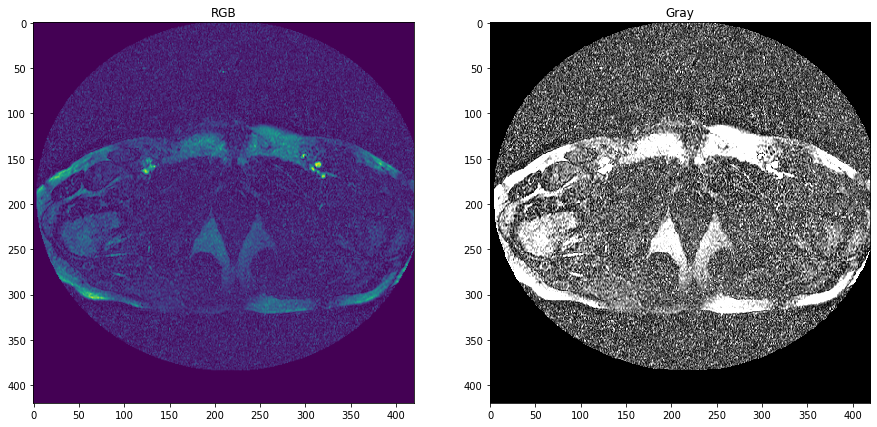

In [7]:
patient_images = small_data[0]
print(f"Image shape: {patient_images[0].shape}\n\n")

nRow = 1
nCol = 2
fig, axis = plt.subplots(nRow, nCol, figsize=(15, 8))

axis[0].imshow(patient_images[0])
axis[0].title.set_text('RGB')

axis[1].imshow(patient_images[0], cmap='gray', vmin=0, vmax=255, interpolation='none')
axis[1].title.set_text('Gray')

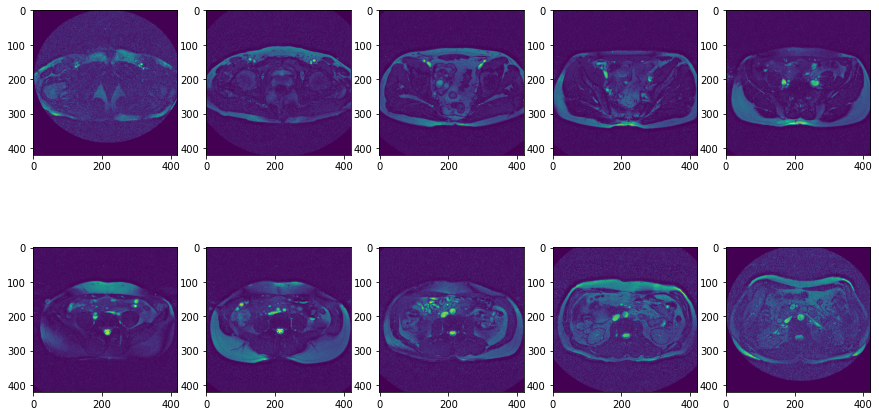

In [8]:
nRows = 2
nCols = 5
fig, axis = plt.subplots(nRows, nCols, figsize=(15, 8))
for row in range(nRows):
  for col in range(nCols):
    axis[row][col].imshow(patient_images[row*nCols+col])

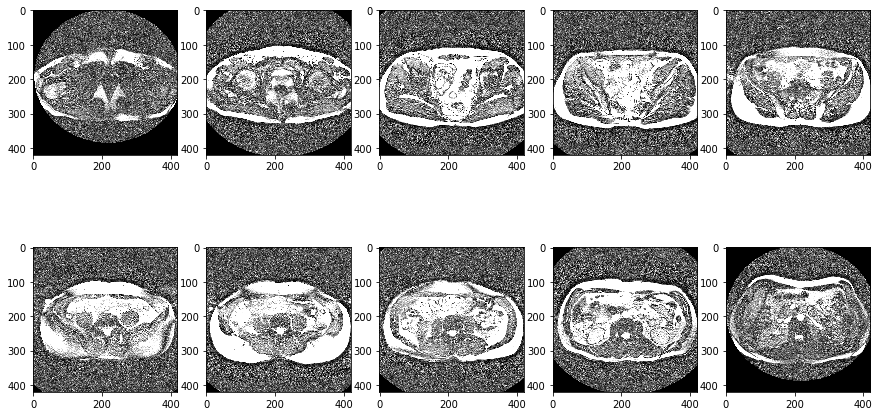

In [9]:
nRows = 2
nCols = 5
fig, axis = plt.subplots(nRows, nCols, figsize=(15, 8))
for row in range(nRows):
  for col in range(nCols):
    axis[row][col].imshow(patient_images[row*nCols+col], cmap='gray', vmin = 0, vmax = 255, interpolation='none')

In [10]:
# 7 classes falls into 2 classes (Normal and Operated)
# Normal --> 0   &   Operated --> 1
all_target['CEAP'] = (all_target['CEAP'] > 3).astype(int)
all_target.shape

(81, 1)

### **Leave-One-Out cross validation**

In [11]:
# Select 2 patients and 5 patients as class 1 and 0 respectively
# At the end take an average of the all 6 experiments
normal_ind = all_target.index[all_target['CEAP'] == 0].tolist()
operated_ind = all_target.index[all_target['CEAP'] == 1].tolist()

#new_normal_ind = np.reshape(normal_ind, [math.floor(len(normal_ind)/5), 5])
new_normal_ind = np.full((math.ceil(len(normal_ind)/5), 5), np.nan, dtype=int)
new_normal_ind.ravel()[:len(normal_ind)] = normal_ind
new_normal_ind = new_normal_ind[:-1]

#new_operated_ind = np.reshape(operated_ind, [math.floor(len(operated_ind/2)) ,2])
new_operated_ind = np.full((math.ceil(len(operated_ind)/2), 2), np.nan, dtype=int)
new_operated_ind.ravel()[:len(operated_ind)] = operated_ind
new_operated_ind = new_operated_ind[:-1]

# Produce 6 index randomly from range(0, 13) for selecting from class 0
random_list_class0 = []
for i in range(0, 6):
  random_list_class0 = random.sample(range(13), 6)

## **CNN Model**

In [ ]:
dir_path = '/content/drive/MyDrive/Master_Thesis/Experiment_result'
datasetUrl = '/content/drive/MyDrive/Master_Thesis/Experiment_result'

# Store all accuracy for all experiments
accuracy_history = []

ind_patients = range(0, 81)
for exper in range(len(new_operated_ind)):
  
  print(f'&& Experiment No. {exper+1} &&')
  # index of patients for test
  ind_x_test = [i for i in new_normal_ind[random_list_class0[exper]]]
  ind_x_test.extend(new_operated_ind[exper])

  # index of patients for train
  ind_x_train = [i for i in range(len(small_data)) if i not in ind_x_test]
  
  # store test data
  X_test = np.array([small_data[i] for i in ind_x_test])
  y_test = np.array([all_target['CEAP'][i] for i in ind_x_test])

  # store train data
  X_train = np.array([small_data[i] for i in ind_x_train])
  y_train = np.array([all_target['CEAP'][i] for i in ind_x_train])

  # Each patient has 10 MRI images with the same class
  X_test = np.reshape(X_test, (70, img_size, img_size))
  y_test = np.repeat(y_test, 10)

  X_train = np.reshape(X_train, (740, img_size, img_size))
  y_train = np.repeat(y_train, 10)

  # ---------------------------------------------------------------------------------------------------------
  
  # Just augmenting sample 1 (Operated patients)
  aug_x_train, aug_y_train = [], []
  for i in range(len(X_train)):

    class_ = y_train[i]
    img = X_train[i]
    aug_x_train.append(img)
    aug_y_train.append(class_)

    if class_ == 1:
      rand1 = random.randint(10, 35)
      rand2 = random.randint(35, 70)
      aug_x_train.append(imutils.rotate(img, rand1))
      aug_y_train.append(class_)

      aug_x_train.append(imutils.rotate(img, rand2))
      aug_y_train.append(class_)

  aug_x_train = np.array(aug_x_train)
  aug_y_train = pd.DataFrame(aug_y_train)
  aug_y_train.columns = ['CEAP']

  # ---------------------------------------------------------------------------------------------------------

  # train-validation split
  x_tra, x_val, y_tra, y_val = train_test_split(aug_x_train, aug_y_train, test_size = 0.1, random_state=12, shuffle=True)

  ## One-hot encoding of the categorical targets
  y_test = pd.DataFrame(np_utils.to_categorical(y_test, 2))
  y_tra = pd.DataFrame(np_utils.to_categorical(y_tra, 2))
  y_val = pd.DataFrame(np_utils.to_categorical(y_val, 2))

  # ---------------------------------------------------------------------------------------------------------

  # Calculate the class_weight
  # Because our data is highly imbalance
  # Calculate class weight
  class_weight ={}
  for j in range(0,2):
    class_weight[j] = (sum(y_tra.iloc[:,0]) + sum(y_val.iloc[:,0])) / (sum(y_tra.iloc[:,j]) + sum(y_val.iloc[:,j]))

  '''
  # Over Sampling
  oversample = SMOTE()
  all_data = all_data.reshape((810, -1))
  all_data, all_data_targets = oversample.fit_resample(all_data, all_data_targets)

  # Reshaping
  # From numpy to torch
  all_data = torch.from_numpy(all_data)
  all_data = all_data.unsqueeze(1).reshape((1360, 300, 300))
  all_data = all_data.numpy()
  ''';
  # ---------------------------------------------------------------------------------------------------------

  # Lets define CNN model
  cnn_ = models.Sequential()
  cnn_.add(Input(shape=(img_size, img_size, 1)))
  cnn_.add(GaussianNoise(0.2))

  cnn_.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
  cnn_.add(BatchNormalization())
  cnn_.add(MaxPooling2D(3))
  cnn_.add(Dropout(0.25))

  cnn_.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
  cnn_.add(BatchNormalization())
  cnn_.add(MaxPooling2D(3))
  cnn_.add(Dropout(0.25))

  cnn_.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
  cnn_.add(BatchNormalization())
  cnn_.add(MaxPooling2D(3))
  cnn_.add(Dropout(0.25))

  cnn_.add(GlobalAveragePooling2D())
  cnn_.add(Dropout(0.25))

  cnn_.add(Dense(16, activation='relu'))
  cnn_.add(Dense(2, activation='softmax'))

  # plot_model(cnn_, "CNN.png", show_shapes=True)

  callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
  cnn_.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  history_2 = cnn_.fit(x_tra,
                       y_tra,
                       validation_data=(x_val, y_val),
                       epochs=50,
                       #class_weight=class_weight,
                       callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)])

  scores = cnn_.evaluate(X_test, y_test, verbose=0)
  accuracy_history.append([scores[1]*100, scores[0]])

  #json.dump(str(history.history), open(f"{dir_path}/History.pkl", "w"))
  json.dump(str(history_2.history), open(f"{dir_path}/History_{exper}.pkl", "w"))
  cnn_.save(f'{dir_path}/cnn_{exper}.h5')

  print('\n\n')
  print('*' * 100)
  print('\n\n')
  #pred = pd.DataFrame(cnn_.predict(X_test))
  #print(classification_report(np.argmax(y_val.values, axis=1), np.argmax(cnn_.predict(x_val), axis=1), digits=4))

&& Experiment No. 1 &&
Epoch 1/50
27/27 [==============================] - 27s 471ms/step - loss: 0.4696 - accuracy: 0.8148 - val_loss: 0.5429 - val_accuracy: 0.6667
Epoch 2/50
27/27 [==============================] - 11s 421ms/step - loss: 0.3737 - accuracy: 0.8715 - val_loss: 0.5525 - val_accuracy: 0.6667
Epoch 3/50
27/27 [==============================] - 12s 429ms/step - loss: 0.3550 - accuracy: 0.8773 - val_loss: 0.3918 - val_accuracy: 0.8958
Epoch 4/50
27/27 [==============================] - 11s 423ms/step - loss: 0.3362 - accuracy: 0.8866 - val_loss: 0.3549 - val_accuracy: 0.8958
Epoch 5/50
27/27 [==============================] - 12s 431ms/step - loss: 0.3344 - accuracy: 0.8889 - val_loss: 0.3270 - val_accuracy: 0.8958
Epoch 6/50
27/27 [==============================] - 11s 423ms/step - loss: 0.3221 - accuracy: 0.8843 - val_loss: 0.3368 - val_accuracy: 0.8958
Epoch 7/50
27/27 [==============================] - 11s 423ms/step - loss: 0.3219 - accuracy: 0.8866 - val_loss: 0.3167

### **Test Accuracy**

In [ ]:
all_acc = 0
for i in range(len(accuracy_history)):
  all_acc += accuracy_history[i][0]

avg_acc = all_acc/len(accuracy_history)
print(f"Avg test accuracy: {avg_acc}")

Avg test accuracy: 62.142858654260635


In [ ]:
# Loss plot
plt.figure(figsize=(10, 6))
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'], '--')
plt.legend(['train loss', 'validation loss'])

In [ ]:
# Prediction
pred = pd.DataFrame(cnn_.predict(X_test))

x = [ i for i in range(0,408)]
plt.figure(figsize=(20,8))
plt.plot(x,  np.argmax(pred.values ,axis=1), '.r')
plt.plot(x,  np.argmax(y_test.values ,axis=1), '.b')
plt.legend([ 'Y_pred', 'Y_test'])

In [ ]:
LABELS = ['Normal', 'Operated']
def show_confusion_matrix(matrix):
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,cmap="Reds",linecolor='white',linewidths=1,
                xticklabels=LABELS,yticklabels=LABELS,annot=True,fmt=".2f")    
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

def confusion_matrix(validations, predictions):        
    matrix = metrics.confusion_matrix(validations, predictions)        
    print('matrix frequency')
    show_confusion_matrix(matrix) # show for frequency    

    
    sensitivity =  np.divide(matrix.transpose(),np.sum(matrix, axis=1)).transpose() * 100
    show_confusion_matrix(sensitivity) # show for sensitivity

print("\n--- Confusion matrix for train data ---\n")
confusion_matrix(np.argmax(y_tra.values, axis=1), np.argmax(cnn_.predict(x_tra), axis=1))

In [ ]:
# Classification report
print(classification_report(np.argmax(y_val.values, axis=1), np.argmax(cnn_.predict(x_val), axis=1), digits=4))

### **Saliency Map**

In [ ]:
def seliency(_img, model):

  #preprocess image to get it into the right format for the model
  img = keras.preprocessing.image.img_to_array(_img)
  img = img.reshape((1, *img.shape))
  y_pred = model.predict(img)

  images = tf.Variable(img, dtype=float)
  with tf.GradientTape() as tape:
      pred = model(images, training=False)
      class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
      loss = pred[0][class_idxs_sorted[0]]
    
  grads = tape.gradient(loss, images)
  dgrad_abs = tf.math.abs(grads)

  dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

  ## normalize to range between 0 and 1
  arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
  grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

  fig, axes = plt.subplots(1,2,figsize=(14,5))
  axes[0].imshow(_img, cmap='gray')
  i = axes[1].imshow(grad_eval,cmap="jet", alpha=0.8)
  fig.colorbar(i)

True class label: 0




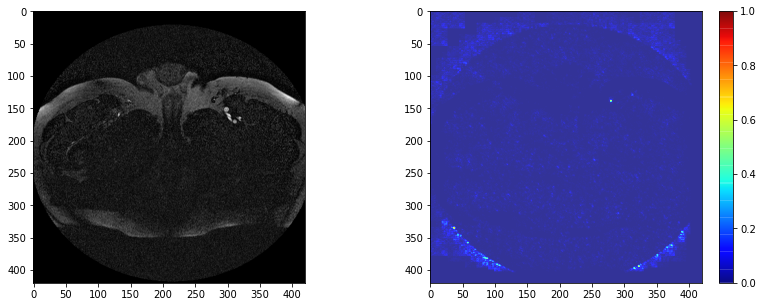

In [ ]:
# Class 0 --> random_list_class0
sample_no = 40
print(f"True class label: {np.argmax(y_test.values, axis=1)[sample_no]}\n\n")

_img = X_test[sample_no]
seliency(_img, cnn_)

True class label: 0




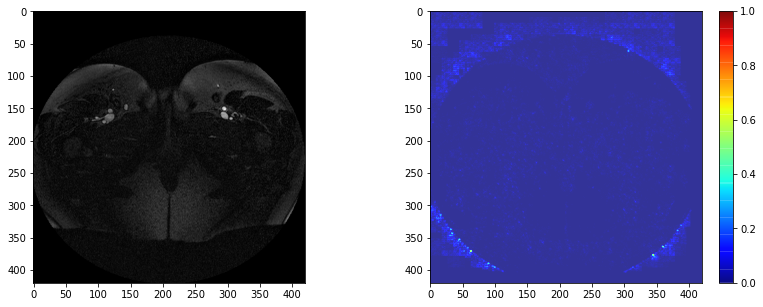

In [ ]:
# Class 0 --> random_list_class0
sample_no = 20
print(f"True class label: {np.argmax(y_test.values, axis=1)[sample_no]}\n\n")

_img = X_test[sample_no]
seliency(_img, cnn_)

True class label: 1




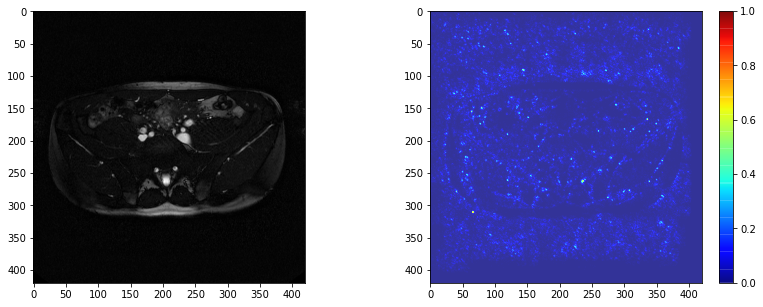

In [ ]:
# Class 0 --> random_list_class0
sample_no = 65
print(f"True class label: {np.argmax(y_test.values, axis=1)[sample_no]}\n\n")

_img = X_test[sample_no]
seliency(_img, cnn_)

True class label: 1




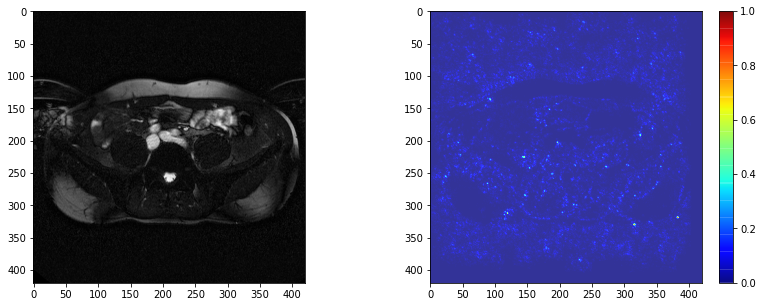

In [ ]:
# Class 0 --> random_list_class0
sample_no = 55
print(f"True class label: {np.argmax(y_test.values, axis=1)[sample_no]}\n\n")

_img = X_test[sample_no]
seliency(_img, cnn_)

# **Pre-Trained Model**

In [12]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import SGD

from os import path
import json
import shutil
from imageio import imread

### Data Preparation

In [17]:
dir_path = '/content/drive/MyDrive/Master_Thesis/Experiment_result_InceptionV3'
datasetUrl = '/content/drive/MyDrive/Master_Thesis/Experiment_result_InceptionV3'

# Store all accuracy for all experiments
accuracy_history = []

ind_patients = range(0, 81)
for exper in range(len(new_operated_ind)):
  
  print(f'&& Experiment No. {exper+1} &&')
  # index of patients for test
  ind_x_test = [i for i in new_normal_ind[random_list_class0[exper]]]
  ind_x_test.extend(new_operated_ind[exper])

  # index of patients for train
  ind_x_train = [i for i in range(len(small_data)) if i not in ind_x_test]
  
  # store test data
  X_test = np.array([small_data[i] for i in ind_x_test])
  y_test = np.array([all_target['CEAP'][i] for i in ind_x_test])

  # store train data
  X_train = np.array([small_data[i] for i in ind_x_train])
  y_train = np.array([all_target['CEAP'][i] for i in ind_x_train])

  # Each patient has 10 MRI images with the same class
  X_test = np.reshape(X_test, (70, img_size, img_size))
  y_test = np.repeat(y_test, 10)

  X_train = np.reshape(X_train, (740, img_size, img_size))
  y_train = np.repeat(y_train, 10)

  # ---------------------------------------------------------------------------------------------------------
  
  # Just augmenting sample 1 (Operated patients)
  aug_x_train, aug_y_train = [], []
  for i in range(len(X_train)):

    class_ = y_train[i]
    img = X_train[i]
    aug_x_train.append(img)
    aug_y_train.append(class_)

    if class_ == 1:
      rand1 = random.randint(10, 35)
      rand2 = random.randint(35, 70)
      aug_x_train.append(imutils.rotate(img, rand1))
      aug_y_train.append(class_)

      aug_x_train.append(imutils.rotate(img, rand2))
      aug_y_train.append(class_)

  aug_x_train = np.array(aug_x_train)
  aug_y_train = pd.DataFrame(aug_y_train)
  aug_y_train.columns = ['CEAP']

  # ---------------------------------------------------------------------------------------------------------

  # train-validation split
  x_tra, x_val, y_tra, y_val = train_test_split(aug_x_train, aug_y_train, test_size = 0.1, random_state=12, shuffle=True)

  ## One-hot encoding of the categorical targets
  y_tra = pd.DataFrame(np_utils.to_categorical(y_tra, 2))
  y_val = pd.DataFrame(np_utils.to_categorical(y_val, 2))

  # Calculate the class_weight
  # Because our data is highly imbalance
  # Calculate class weight
  class_weight ={}
  for j in range(0,2):
    class_weight[j] = (sum(y_tra.iloc[:,0]) + sum(y_val.iloc[:,0])) / (sum(y_tra.iloc[:,j]) + sum(y_val.iloc[:,j]))

  print(class_weight)

  # ---------------------------------------------------------------------------------------------------------

  # Store images to folders
  class_name = ['0', '1']
  path = "./Cardiovascular"

  for i in range(0, 2):
    _path = f"{path}/{i}"
    !mkdir -p {_path}

  for i in range(len(aug_x_train)):
    img = aug_x_train[i]
    class_name = aug_y_train['CEAP'][i]
    file_name = f"img{i}_{class_name}"
    plt.imsave(f"{path}/{class_name}/{file_name}.png", img)

  # Save as archive (.zip)
  shutil.make_archive("Cardiovascular_binary_oversample", "zip", "./Cardiovascular")

  # ---------------------------------------------------------------------------------------------------------
  !mkdir -p "Cardiovascular_binary_oversample"
  !unzip "./Cardiovascular_binary_oversample.zip" -d "./Cardiovascular_binary_oversample"

  # Make train test folders
  path = './Cardiovascular_binary_oversample'
  for _class in ['0', '1']:
      dir1 = f"{path}/{_class}"    
      files = glob.glob(f"{dir1}/*.png")
      #train, test = train_test_split(files, test_size=0.2, shuffle=False) # 20% test 16% val 64% train
      train, val = train_test_split(files, test_size=0.2, shuffle=False) 
      for type_name, urls in [["train", train], ["val", val]]:           
        dir2 = f"{path}/{type_name}/{_class}"
        !mkdir -p {dir2}
        for url in urls:
          file_name = url[len(dir1)+1:]
          shutil.move(url, f"{dir2}/{file_name}")

      !rm -r {dir1}
      #!rm -r "./Cardiovascular_binary/Cardiovascular_binary.zip"

  !mkdir -p {"./Cardiovascular_binary_oversample/test/0"}
  !mkdir -p {"./Cardiovascular_binary_oversample/test/1"}
  path = './Cardiovascular_binary_oversample/test'
  for i in range(len(X_test)):
    img = X_test[i]
    class_name = y_test[i]
    file_name = f"img{i}_{class_name}"
    plt.imsave(f"{path}/{class_name}/{file_name}.png", img)

  # ---------------------------------------------------------------------------------------------------------

  # Make generator
  groups = ['0', '1']
  dir_path = './Cardiovascular_binary_oversample'
  datasetUrl = './Cardiovascular_binary_oversample'

  target_size = (img_size, img_size)
  batch_size = 32
  num_classes = len(groups)

  # Data generator

  train_datagen = ImageDataGenerator(rescale=1./255,
                              featurewise_center=True,
                              samplewise_center=True,
                              featurewise_std_normalization=True,
                              samplewise_std_normalization=True,
                              zca_whitening=True,
                              zca_epsilon=1e-03,
                              rotation_range=0,
                              width_shift_range=0,
                              height_shift_range=0,
                              brightness_range=[1,1],
                              shear_range=1,
                              zoom_range=0,                             
                              fill_mode="nearest",
                              cval=0.5,
                              horizontal_flip=True,
                              vertical_flip=True)

  train_generator = train_datagen.flow_from_directory(
          f'{datasetUrl}/train', 
          target_size=target_size,
          batch_size=batch_size,
          class_mode='categorical',
          classes = groups )  # since we use binary_crossentropy loss, we need binary labels        


  #validation_datagen = ImageDataGenerator(rescale=1./255)

  validation_generator = train_datagen.flow_from_directory(
          f'{datasetUrl}/val', 
          target_size=target_size,
          batch_size=batch_size,
          class_mode='categorical',
          classes = groups )  # since we use binary_crossentropy loss, we need binary labels 


  test_datagen = ImageDataGenerator(rescale=1./255,
                                  featurewise_center=True,
                                  samplewise_center=True,
                                  featurewise_std_normalization=True,
                                  samplewise_std_normalization=True,)

  test_generator = test_datagen.flow_from_directory(
          f'{datasetUrl}/test', 
          target_size=target_size,
          batch_size=batch_size,
          class_mode='categorical',
          classes = groups )  # since we use binary_crossentropy loss, we need binary labels

  # ---------------------------------------------------------------------------------------------------------

  # Inception V3 Model
  base_model = InceptionV3(weights='imagenet', include_top=False)

  num_classes = len(groups)
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.5)(x)
  x = Dense(64, activation='relu')(x)
  x = Dense(32, activation='relu')(x)
  predictions = Dense(num_classes, activation='softmax')(x)
  model = Model(inputs=base_model.input, outputs=predictions)
  for layer in base_model.layers:
      layer.trainable = False

  model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=["accuracy"])

  history = model.fit_generator(train_generator,
        epochs=100,
        validation_data=validation_generator,
        class_weight=class_weight,
        callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)])
  
  # ---------------------------------------------------------------------------------------------------------

  for layer in model.layers[:249]:
    layer.trainable = False
  for layer in model.layers[249:]:
    layer.trainable = True

  model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=["accuracy"])

  history2 = model.fit_generator(train_generator,
          epochs=100,
          validation_data=validation_generator,
          class_weight=class_weight,
          callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)])
  
  json.dump(str(history.history), open(f"{dir_path}/History_{exper}.pkl", "w"))
  json.dump(str(history2.history), open(f"{dir_path}/History2_{exper}.pkl", "w"))
  model.save(f'{dir_path}/cnn__{exper}.h5')

  !rm -r {"./Cardiovascular"}
  !rm -r {"./Cardiovascular_binary_oversample"}
  !rm -r {"./Cardiovascular_binary_oversample.zip"}

&& Experiment No. 1 &&
{0: 1.0, 1: 1.9090909090909092}
Archive:  ./Cardiovascular_binary_oversample.zip
   creating: ./Cardiovascular_binary_oversample/0/
   creating: ./Cardiovascular_binary_oversample/1/
  inflating: ./Cardiovascular_binary_oversample/1/img536_1.png  
  inflating: ./Cardiovascular_binary_oversample/1/img404_1.png  
  inflating: ./Cardiovascular_binary_oversample/1/img753_1.png  
  inflating: ./Cardiovascular_binary_oversample/1/img739_1.png  
  inflating: ./Cardiovascular_binary_oversample/1/img733_1.png  
  inflating: ./Cardiovascular_binary_oversample/1/img672_1.png  
  inflating: ./Cardiovascular_binary_oversample/1/img354_1.png  
  inflating: ./Cardiovascular_binary_oversample/1/img241_1.png  
  inflating: ./Cardiovascular_binary_oversample/1/img334_1.png  
  inflating: ./Cardiovascular_binary_oversample/1/img531_1.png  
  inflating: ./Cardiovascular_binary_oversample/1/img351_1.png  
  inflating: ./Cardiovascular_binary_oversample/1/img302_1.png  
  inflating: .

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:342: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


Found 768 images belonging to 2 classes.
Found 192 images belonging to 2 classes.
Found 70 images belonging to 2 classes.
87924736/87910968 [==============================] - 2s 0us/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
24/24 [==============================] - 430s 18s/step - loss: 0.8938 - accuracy: 0.5820 - val_loss: 0.5320 - val_accuracy: 0.8385
Epoch 2/100
24/24 [==============================] - 417s 17s/step - loss: 0.7910 - accuracy: 0.6641 - val_loss: 0.4387 - val_accuracy: 0.8281
Epoch 3/100
24/24 [==============================] - 418s 17s/step - loss: 0.7043 - accuracy: 0.7331 - val_loss: 0.4206 - val_accuracy: 0.8490
Epoch 4/100
24/24 [==============================] - 418s 17s/step - loss: 0.6546 - accuracy: 0.7852 - val_loss: 0.3766 - val_accuracy: 0.8750
Epoch 5/100
24/24 [==============================] - 476s 20s/step - loss: 0.6207 - accuracy: 0.8008 - val_loss: 0.4252 - val_accuracy: 0.7760
Epoch 6/100
24/24 [==============================] - 477s 20s/step - loss: 0.6186 - accuracy: 0.7669 - val_loss: 0.3840 - val_accuracy: 0.8594
Epoch 7/100
24/24 [==============================] - 418s 17s/step - loss: 0.6250 - accuracy: 0.7956 - val_loss: 0.4205 - val_accuracy: 0.8073

KeyboardInterrupt: ignored

### **Test Accuracy**

In [ ]:
all_acc = 0
for i in range(len(accuracy_history)):
  all_acc += accuracy_history[i][0]

avg_acc = all_acc/len(accuracy_history)
print(f"Avg test accuracy: {avg_acc}")

In [ ]:
# Assesment for experiment 0 (first experiment)

model = keras.models.load_model(f"{dir_path}/cnn_0.h5")
with open(f"{dir_path}/History_0.pkl",'r') as file:    
    history = eval(file.read().replace('"',"").replace("\'","'"))

In [ ]:
# Loss plot of the last experiment
plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')    
plt.plot(history['loss'],linewidth=3)
plt.plot(history['val_loss'],linewidth=3)
plt.title(f'Train and validation loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'])
plt.show()

In [ ]:
# Prediction accuracy of the last experiment
plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')    
plt.plot(history['accuracy'],linewidth=3)
plt.plot(history['val_accuracy'],linewidth=3)
plt.title(f'Train and validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'])
plt.show()

In [ ]:
# Confusion matrix for test data
y_true = []
y_pred = []
for i in range(0,len(test_generator)):
    y_true = [*y_true, *[i for i in np.argmax(test_generator[i][1],axis=1)]]    
    y_pred = [*y_pred, *[i for i in np.argmax(model.predict_on_batch(test_generator[i][0]),axis=1)]]

In [ ]:
matrix = metrics.confusion_matrix(y_true, y_pred)            
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')        
ax = sns.heatmap(matrix,cmap="Blues",linecolor='black',linewidths=1.7,xticklabels=groups, yticklabels=groups, annot=True,fmt="d")    
plt.title("Confusion Matrix frequance")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [ ]:
# Sensitivity
sensitivity =  np.divide(matrix.transpose(),np.sum(matrix, axis=1)).transpose() * 100

plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')        
ax = sns.heatmap(sensitivity,cmap="Blues",linecolor='black',linewidths=1.7,xticklabels=groups, yticklabels=groups, annot=True,fmt=".1f")    
plt.title("Confusion Matrix percentage")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
for t in ax.texts: t.set_text(t.get_text() + "%")
plt.show()

In [ ]:
# Classification report
print(classification_report(y_true, y_pred,digits=4))